In [1]:
import sys
sys.path.append("../")

In [2]:
from pathlib import Path
# import numpy as np
import jax.numpy as np
import pandas as pd
import jax
import jraph
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

/tmp/ipykernel_167543/4084619450.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
data_dir = Path('/n/holystore01/LABS/iaifi_lab/Lab/set-diffuser-data/val_split/')
halos = np.load(data_dir / 'train_halos.npy')

n_nodes = 5000
halos =  halos[:, :n_nodes, :]

halos_test = np.load(data_dir / 'test_halos.npy')
halos_test =  halos_test[:, :n_nodes, :]

## Prepare data

In [4]:
cosmology = pd.read_csv(data_dir / f'train_cosmology.csv')
cosmology_test = pd.read_csv(data_dir / f'test_cosmology.csv')
print(len(cosmology))

1600


In [5]:
cosmology.head(3)

,Omega_m,Omega_b,h,n_s,sigma_8
0,0.1755,0.06681,0.7737,0.8849,0.6641
1,0.2139,0.05557,0.8599,0.9785,0.8619
2,0.1867,0.04503,0.6189,0.8307,0.7187


In [6]:
omega_m = np.array(cosmology['Omega_m'].values)[:,None]
omega_m_test = np.array(cosmology_test['Omega_m'].values)[:,None]

## Train EGNN

In [7]:
import flax
from flax.training.train_state import TrainState
from functools import partial
import flax.linen as nn
import optax
from tqdm import trange

replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate

In [8]:
from graph_utils import build_graph

In [9]:
n_feat = 3

halo_pos_mean = halos[..., :n_feat].mean((0,1))
halo_pos_std = halos[..., :n_feat].std((0,1))

In [10]:
halo_pos = (halos[..., :n_feat] - halo_pos_mean)  / halo_pos_std
halo_pos_test = (halos_test[..., :n_feat] - halo_pos_mean)  / halo_pos_std

In [28]:
import sys
sys.path.append("../../")

from models.segnn_old import SEGNN
from e3nn_jax import Irreps
from irreps_utils import balanced_irreps

l_attr = 2
hidden_feats = 64

irreps_sh = Irreps.spherical_harmonics(l_attr)
irreps_hidden = balanced_irreps(lmax=l_attr, feature_size=hidden_feats, use_sh=True)

class GraphWrapper(nn.Module):
    @nn.compact
    def __call__(self, x):
        model = jax.vmap(SEGNN(task='graph'))
        return model(x)

from graph_utils import build_graph_irreps as build_graph

In [29]:
# from models.equivariant_transformer import EquivariantTransformer
# import e3nn_jax as e3nn

# class GraphWrapper(nn.Module):
#     @nn.compact
#     def __call__(self, x):
        
#         # Position and feature irreps arrays. Add the mass to the conditioning vectors.
#         pos = e3nn.IrrepsArray("1o", x.nodes[..., :3])
#         feat = e3nn.IrrepsArray(f"1o + 1x0e", x.nodes[..., 3:])

#         return jax.vmap(EquivariantTransformer(irreps_out="16x1o + 16x0e", d_hidden=64))(pos, feat, x.senders, x.receivers,)

In [30]:
k = 20
use_pbc = True
use_edges = False

graph = build_graph(halo_pos[:4, :, :3], k=k, use_pbc=use_pbc, use_edges=use_edges)

In [31]:
model = GraphWrapper()

key = jax.random.PRNGKey(0)
out, params = model.init_with_output(key, graph)

In [32]:
out

Array([[1.3387794],
       [1.3818202],
       [1.350208 ],
       [1.3822459]], dtype=float32)

In [33]:
sum(x.size for x in jax.tree_util.tree_leaves(params))

67969

In [34]:
# Devices
num_local_devices = jax.local_device_count()
print(f"{num_local_devices} GPUs available")

4 GPUs available


In [36]:
# Define train state and replicate across devices
tx = optax.adamw(learning_rate=3e-4, weight_decay=1e-5)
state = TrainState.create(apply_fn=model.apply, params=params, tx=tx)
pstate = replicate(state)

In [37]:
def loss_mse(pred_batch, cosmo_batch,):
    return np.mean((pred_batch - cosmo_batch) ** 2)

@partial(jax.pmap, axis_name="batch",)
def train_step(state, halo_batch, cosmo_batch,):

    # Build graph
    halo_graph = build_graph(halo_batch, k=k, use_pbc=use_pbc, use_edges=use_edges)
    
    def loss_fn(params):
        outputs = state.apply_fn(params, halo_graph)
        loss = loss_mse(outputs, cosmo_batch)
        return loss

    # Get loss, grads, and update state
    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    grads = jax.lax.pmean(grads, "batch")
    new_state = state.apply_gradients(grads=grads)
    metrics = {"loss": jax.lax.pmean(loss, "batch")}
    
    return new_state, metrics

In [38]:
n_steps = 10000
n_batch = 8
n_train = 1600 

key = jax.random.PRNGKey(0)

with trange(n_steps) as steps:
    for step in steps:
        key, subkey = jax.random.split(key)
        idx = jax.random.choice(key, halo_pos.shape[0], shape=(n_batch,))
        
        # halo_batch, cosmo_batch = halo_pos[:n_train][idx], omega_m[:n_train][idx]
        halo_batch, cosmo_batch = halo_pos[:n_batch], omega_m[:n_batch]  # Overfit on a small sample

        # Split batches across devices
        halo_batch = jax.tree_map(lambda x: np.split(x, num_local_devices, axis=0), halo_batch)
        cosmo_batch = jax.tree_map(lambda x: np.split(x, num_local_devices, axis=0), cosmo_batch)
        halo_batch, cosmo_batch = np.array(halo_batch), np.array(cosmo_batch)

        pstate, metrics = train_step(pstate, halo_batch, cosmo_batch)
        
        steps.set_postfix(loss=unreplicate(metrics["loss"]))

100%|██████████| 10000/10000 [08:20<00:00, 19.99it/s, loss=0.00080041104]


100%|██████████| 20/20 [00:51<00:00,  2.59s/it]


Text(0, 0.5, 'Predicted')

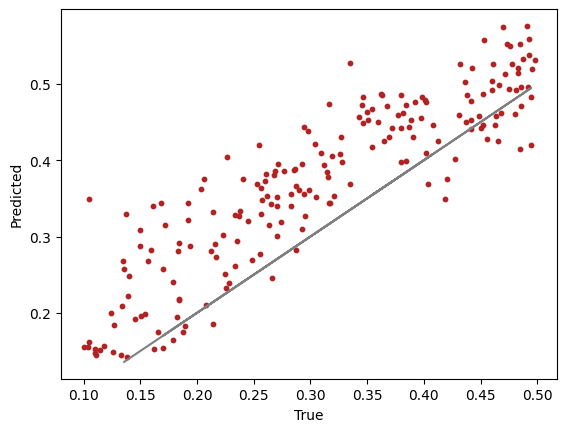

In [39]:
from tqdm import tqdm

n_test_batch = 10
n_test_batches = len(halo_pos_test) // n_test_batch

for i in tqdm(range(n_test_batches)):

    # TODO: jit/pmap
    graph = build_graph(halo_pos_test[i * n_test_batch:(i + 1) * n_test_batch], k=k, use_pbc=use_pbc, use_edges=use_edges)
    omega_m_pred = jax.jit(model.apply)(unreplicate(pstate).params, graph)

    plt.scatter(omega_m_test[i * n_test_batch:(i + 1) * n_test_batch], omega_m_pred[:, 0], s=10, color='firebrick')
    
plt.plot(omega_m_test[:n_test_batch], omega_m_test[:n_test_batch], color='gray')

plt.xlabel("True")
plt.ylabel("Predicted")